In [1]:
push!(LOAD_PATH, "./")
using PyPlot
using BdgSolver

# Chemical potential, number of occupied bands and Density of states

In [2]:
# Common values
mat = Material("Sn", 0.021931, 0.000618, 0.666666)
h22m = 0.5
μ2D = 0.5 * 2 * π * mat.ρ
μ3D = 0.5 * (3 * π^2 * mat.ρ)^(2/3)
N0_3D = 0.5*1/h22m * sqrt(μ3D/h22m)/(2.0*π^2) # factor 2
g_3D = mat.λ / N0_3D

nLzs = 500
Lzs = linspace(10, 100, nLzs)
shs = [Shape(1000, 1000, Lz) for Lz in Lzs]
pars = [Parameters(mat, sh) for sh in shs]
hams = [Hamiltonian(mat, shs[i], pars[i]) for i in 1:nLzs]

μs = [p.μ for p in pars]
νs = [p.ν for p in pars]
Ns = [evaluate_at(hams[i].DOS, μs[i]) for i in 1:nLzs];

## Chemical potential
The chemical potential for a pseudo-2D system is calculated as
$$\mu = \pi \frac{\hbar^2}{m} \frac{L_z}{\nu} \left( \rho + \frac{\pi}{6 L_z^3} \nu (\nu + \frac{1}{2})(\nu + 1)\right). $$
This needs to be solved self-consistently, since the number of occupied bands $\nu$ depends on $\mu$ as well:
$$ \nu = \left\lfloor \frac{L_z}{\pi}\sqrt{\frac{2m(\mu + \hbar\omega_D)}{\hbar^2}}\right\rfloor.$$

We can wonder how this interpolates between the 2D and 3D results:
$$\begin{align}
\mu_{\mathrm{2D}} &= \frac{\hbar^2}{2m} (2\pi \rho) \\
\mu_{\mathrm{3D}} &= \frac{\hbar^2}{2m} (3\pi^2\rho)^{2/3}.
\end{align}
$$

To check this, we simply plot $\mu$ for varying thickness:

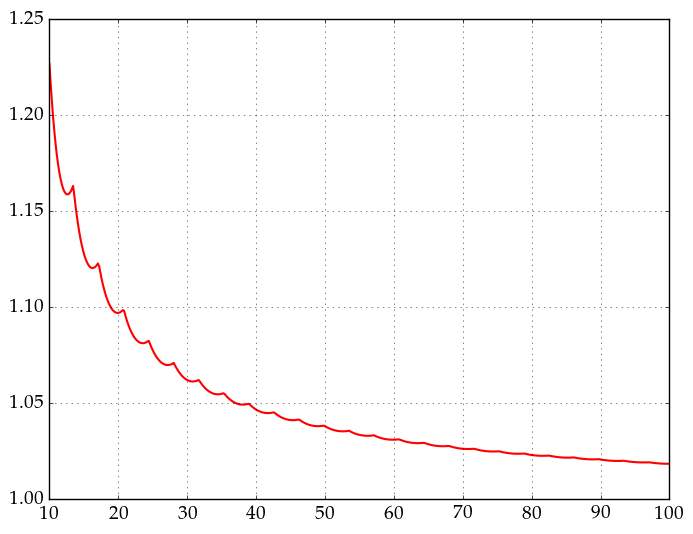

In [ ]:
ax = gca()
#plot(Lzs, μs/μ2D, color="blue", linewidth=1.5)
plot(Lzs, μs/μ3D, color="red", linewidth=1.5)
show()

Clearly, as we reach the bulk limit, the quasi-2D result converges to the 3D result: the red curve is $\mu$ relative to $\mu_{\mathrm{3D}}$, and converges to 1 as the thickness grows. The blue curve is $\mu/\mu_\textrm{2D}$, and clearly *does not* converge to 1 as the thickness decreases!

## Number of occupied bands
The number of occupied bands $\nu$, naively, looks as if it should scale $\sim L_z$.

In [ ]:
ax = gca()
plot(Lzs, νs, color="blue", linewidth=1.5)
show()

## Density of states at the Fermi level

The Density of states for ideal 2D and 3D systems, as given by [1] (slide 17):
$$
\begin{align}
N_\textrm{3D}(\xi) & = \frac{1}{2\pi^2} \frac{2m}{\hbar^2} \sqrt{\frac{2 m \xi}{\hbar^2}}\\
N_\textrm{2D}(\xi) & = \frac{1}{2\pi}\frac{2m}{\hbar^2} \theta(\xi).
\end{align}
$$

The Density of states for a finite, ideal 2D system with sides $L$ is given by:
$$ N_L(\xi) = \frac{1}{2\pi}\frac{2m}{\hbar^2} L^2.$$
Usually, we simply use the density of states per unit volume, by dividing out the $L^2$:
$$N_\mathrm{2D}(\xi) = \frac{1}{2\pi}\frac{2m}{\hbar^2}.$$

In the case of a quasi-2D sample, however, dividing by the volume of the crystal instead yields
$$N_\mathrm{q2D}(\xi) = \frac{1}{2\pi L_z}\frac{2m}{\hbar^2}.$$

This is necessary, because this is the $L_z$ dependency that yields the correct 3D result in the large
$L_z$ limit.


[1]: http://users.ece.gatech.edu/~alan/ECE6451/Lectures/StudentLectures/King_Notes_Density_of_States_2D1D0D.pdf

In [ ]:
ax = gca()
plot(Lzs, Ns/N0_3D, color="blue", linewidth=1.5)
#ax[:set_ylim]([0.00, 1.1]);
show()

## Dimensionful electron-phonon coupling $g$
The electron-phonon coupling $g$ is defined as $g = \lambda/N(\mu)$. The problem is, of course, that it's not quite clear what value for $N(\mu)$ to use here. If we take the exact value, then $g$ will inherit the same oscillatory behaviour from $N$ (though inverted). It should remain fairly bounded, so it shouldn't be too much of a problem, though...

In [ ]:
ax = gca()
plot(Lzs, mat.λ./Ns/g_3D, color="blue", linewidth=1.5)
#ax[:set_ylim]([0.00, 1.1]);
show()

# Integration

Clearly, integrating like this won't be compatible with being able to apply corrections as convolutions to the thermal weight or DOS. I simply can't do "symbolic" integrations for all the corrections and get a function as end result. I'll have to discretize at least part of it, on which I can apply the corrections. I think it's cleanest if I just apply *all* corrections to the DOS:

$$M_{ij} = \Phi_{ij} \int_{DW} d\xi\, N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}$$

If we put in the Debye-window cutoff manually as a characteristic function, $\chi_{DW}(\xi)$, both integrations become completely equivalent (at least in principle).

$$M_{ij} = \Phi_{ij} \int d\xi\, \chi_{DW}(\xi)N_i(\xi) \int d\Xi\, F(\xi - \Xi, \Gamma_\xi) \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}.$$

Reversing the integrations:
$$M_{ij} = \Phi_{ij} \int d\Xi\, \frac{ \textrm{tanh} \frac{\beta_c \Xi}{2}}{\Xi}  \left\{\int d\xi\, F(\xi - \Xi, \Gamma_\xi) \chi_{DW}(\xi)N_i(\xi)\right\}.$$

This way, I can repeatedly keep applying corrections to the DOS. I think. Right?


Note that, if I choose to discretize the DOS, and apply all corrections at the DOS level, I will essentially be multiplying the number of operations (and memory usage) by a factor $\nu$... 

# Thermal determinant

The superconducting and non-superconducting regimes are demarcated by the condition

$$ \det\left(M_{ij} - \delta_{ij}\right) = 0, $$

where $M_{ij}$ is given by

$$M_{ij} = \frac{g}{4} \frac{m}{\pi \hbar^2} \Phi_{ij}
      \int_{DW}d\xi\, \theta(\xi - \epsilon_i) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$
      
Seeing as how, for a 2D system, the density of states can be written as
$$N_i(\xi) = \frac{m}{\pi \hbar^2} \theta(\xi - \epsilon_i), $$
we can rewrite this as
$$M_{ij} = \frac{g}{4} \Phi_{ij}
      \int_{DW}d\xi\, N_i(\xi) \frac{\tanh\left(\frac{\beta_c \xi}{2}\right)}{\xi}.$$

In [ ]:
sh = Shape(1000, 1000, 10)
pars = Parameters(mat, sh)
sys = System(mat, sh, pars)
H = Hamiltonian(mat, sh, pars);
BdgSolver.print_parameters(sys)

### For comparison with the Python code
EF_3D = 0.5 * (3 * π^2 * mat.ρ)^(2/3)
N0_3D = sqrt(EF_3D*2)/(2.0*π^2) # factor 2
EF_2D = 0.5 * 2 * π*mat.ρ
N0_2D = 1/(0.5 * 4 * π) / sh.Lz
N0 = 1/(0.5 * 4 * π) * pars.ν/sh.Lz
bad_g = 0.18/N0_3D

println("EF_3D = $EF_3D")
println("N0_3D = $N0_3D")
println("EF_2D = $EF_2D")
println("N0_2D = $N0_2D")
println("N0 = $N0")
println("g (crappy) = $bad_g")

In [ ]:
Ts, Ds = BdgSolver.get_Tc(sys)
ax=gca()
plot(Ts, Ds, color="blue", linewidth=2.0, linestyle="-")
show()
#fig = figure("Thermal determinant",figsize=(4, 2.5))
#plt[:style][:use]("seaborn-pastel")

The biggest problem I have with this is: my value for $g = \lambda/N(\mu)$ differs immensely from the one I defined in the Python code, $g_\mathrm{Py} = 0.18/N_\mathrm{th}(\mu)$. The Python code defines $g$ through some experimental value for $gN(\mu)$, and divides by the theoretical value $N_\mathrm{th}(\mu)$.

$g$ differs by a factor of about $2\pi$, while $N$ differs by a factor of 10, precisely. Which is funny...

# TODO:
* The total matrix in the thermal part (excluding the $\delta_{ij}$) is orders of magnitude too small. The magnitute about a factor of 4500, the temperature-scale is also off by a HUGE factor (100000 or so). I need to fix these before the determinant of $M_{ij} - \delta_{ij}$ can differ significantly from 1.